# Converting FFHQ images to latent space Z

From:

- https://github.com/CompVis/latent-diffusion#pretrained-autoencoding-models
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

import os
import random
import glob
import wget
import zipfile

import numpy as np

from PIL import Image

import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

from ldm.models.autoencoder import AutoencoderKL

from tqdm import tqdm

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 300

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 40

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [3]:
IMAGE_DIR = "/data/imagefolder/ffhq"
OUTPUT_DIR = "/data/imagefolder/latent/klf4/256"
# OUTPUT_DIR = "/data/imagefolder/latent/klf4/64"
IMAGE_SIZE = 64
WORKERS = 2

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [5]:
def download_pre_trained_ae(url, output_dir):
    if os.path.exists(output_dir):
        print("Used cache")
    else:
        filename = wget.download(url)

        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(output_dir)

        if os.path.exists(filename):
            os.remove(filename)

In [6]:
download_pre_trained_ae("https://ommer-lab.com/files/latent-diffusion/kl-f4.zip", './klf4')

Used cache


In [7]:
ddconfig = {
    "double_z": True,
    "z_channels": 3,
    "resolution": IMAGE_SIZE,
    "in_channels": 3,
    "out_ch": 3,
    "ch": 128,
    "ch_mult": [1,2,4],
    "num_res_blocks": 2,
    "attn_resolutions": [],
    "dropout": 0.0
}
lossconfig = {
      "target": "ldm.modules.losses.LPIPSWithDiscriminator",
      "params": {
        "disc_start": 50001,
        "kl_weight": 1.0e-06,
        "disc_weight": 0.5
      }
}
embed_dim = 3

pl_sd = torch.load("klf4/model.ckpt", map_location="cpu")

model = AutoencoderKL(ddconfig, lossconfig, embed_dim)

model.load_state_dict(pl_sd["state_dict"] ,strict=False)

model.to(device)

model.decoder = nn.DataParallel(model.decoder, list(range(4)))

# def encode(x):
#   with torch.no_grad():
#     return model.encode(x).sample()

# model_ae = AutoencoderKL(ddconfig, lossconfig, embed_dim)

# model_ae.load_state_dict(pl_sd["state_dict"] ,strict=False)

# model_d_device = "cuda:2"
# model_d = model_ae.decoder
# post_quant_conv = torch.nn.Conv2d(embed_dim, ddconfig["z_channels"] * 2, 1).to(model_d_device)
# model_d.to(model_d_device)

def decode(z):
  with torch.no_grad():
    return model.decode(z)

# model.cuda()
# nn.DataParallel(model, list(range(4)))
# model.eval()
print()


making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 16, 16) = 768 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth



In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, (int((ngf * 4 / 64))), 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the generator
netG = Generator().to(device)
netG = nn.DataParallel(netG, list(range(4)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
netG.eval()

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(300, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the Discriminator
netD = Discriminator().to(device)
netD = nn.DataParallel(netD, list(range(4)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    

In [13]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(24, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 0.8
fake_label = 0.2

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
dataset = None

for file in tqdm(glob.glob(f"{OUTPUT_DIR}/*"), total=68):
    if dataset is None:
        dataset = np.load(file)
    else:
        dataset = np.concatenate([dataset, np.load(file)])

100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [01:18<00:00,  1.15s/it]


In [15]:
# np.load(f"{OUTPUT_DIR}/latent_klf4_546.npy").shape

In [16]:
# transform=transforms.Compose([
#         # transforms.ToTensor(),
#         transforms.Normalize(mean=[0,0,0], std=[65,65,65]),
#     ])

# def npy_loader(path):
#     return torch.from_numpy(np.load(path))

# dataset = dset.DatasetFolder(
#     root="/data/imagefolder/latent/klf4",
#     loader=npy_loader,
#     extensions='.npy',
#     transform=transforms.Compose([
#         # transforms.ToTensor(),
#         transforms.Normalize(mean=[0,0,0,0,0,0], std=[7, 7, 7, 7, 7, 7]),
#     ])
# )
# transform=transforms.Compose([
#     # transforms.ToTensor(),
#     transforms.Resize(IMAGE_SIZE),
#     transforms.CenterCrop(IMAGE_SIZE),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
# ])

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)

In [17]:
next(iter(dataloader)).size(0)

128

In [18]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# data_len = 68
norm_scale = 65
data_len = len(dataloader)

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        # data = torch.Tensor(np.load(data)) / norm_scale
        data = data / norm_scale

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # label = torch.full((len(output),), real_label, dtype=torch.float, device=device)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch + 1, num_epochs, i, data_len,
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == data_len-1)):
            with torch.no_grad():
                fake = decode(netG(fixed_noise).to(device) * norm_scale).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

#63 mins

Starting Training Loop...
[1/40][0/544]	Loss_D: 1.9834	Loss_G: 3.5364	D(x): 0.3394	D(G(z)): 0.5036 / 0.0173
[1/40][50/544]	Loss_D: 1.5461	Loss_G: 5.2310	D(x): 0.8558	D(G(z)): 0.5851 / 0.0020
[1/40][100/544]	Loss_D: 2.1037	Loss_G: 6.5558	D(x): 0.6827	D(G(z)): 0.0008 / 0.0004
[1/40][150/544]	Loss_D: 1.5851	Loss_G: 4.7062	D(x): 0.7156	D(G(z)): 0.0073 / 0.0031
[1/40][200/544]	Loss_D: 1.2886	Loss_G: 2.9397	D(x): 0.6962	D(G(z)): 0.0345 / 0.0263
[1/40][250/544]	Loss_D: 1.5300	Loss_G: 3.4655	D(x): 0.6792	D(G(z)): 0.0111 / 0.0140
[1/40][300/544]	Loss_D: 1.0466	Loss_G: 1.3459	D(x): 0.7790	D(G(z)): 0.1980 / 0.1995
[1/40][350/544]	Loss_D: 1.0340	Loss_G: 2.1101	D(x): 0.7929	D(G(z)): 0.2269 / 0.0753
[1/40][400/544]	Loss_D: 1.0316	Loss_G: 1.4945	D(x): 0.7603	D(G(z)): 0.1964 / 0.1628
[1/40][450/544]	Loss_D: 1.0495	Loss_G: 0.9962	D(x): 0.7673	D(G(z)): 0.1202 / 0.3176
[1/40][500/544]	Loss_D: 1.1215	Loss_G: 2.6931	D(x): 0.7864	D(G(z)): 0.3864 / 0.0366
[2/40][0/544]	Loss_D: 1.0705	Loss_G: 0.9531	D(x): 0.8

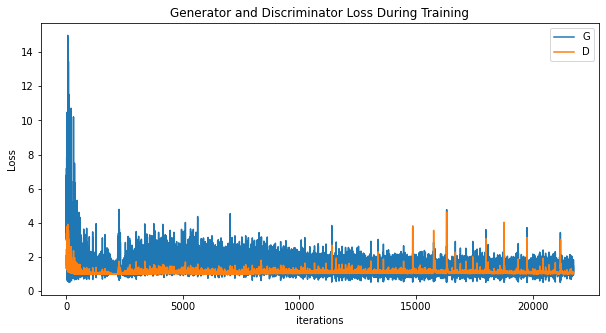

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
torch.save(netG.state_dict(), '/data/imagefolder/models/gen/klf4/generator.pth')

In [21]:
# netG.load_state_dict(torch.load('/data/imagefolder/models/gen/klf4/generator.pth'))

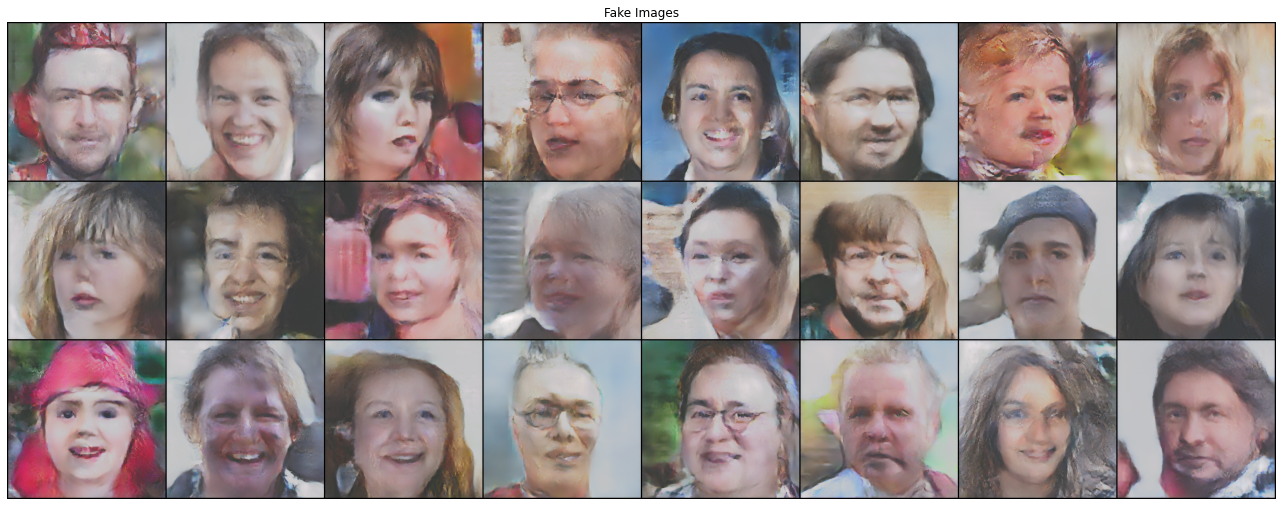

In [22]:
# Grab a batch of real images from the dataloader
# real_batch = next(iter(dataloader))

# # Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# plt.imshow(np.transpose(vutils.make_grid(decode(real_batch[0][0].to(model_d_device)[:4]), padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.figure(figsize=(50,40))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [23]:
# img = Image.open("/data/ffhq/images256x256/40058_256.png")

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize(256),
#     transforms.CenterCrop(256),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# img = transform(img).to(model.device).unsqueeze(0)

# output = model.encode(img) 

# output.sample().cpu().detach().numpy()

In [24]:
def custom_to_pil(x):
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.) / 2.
    x = x.permute(1, 2, 0).numpy()
    x = (255 * x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

In [25]:
SAVE_DIR = "/data/imagefolder/gen_img/klf4/2"

In [26]:
fixed_noise = torch.randn(24, nz, 1, 1, device=device)

with torch.no_grad():
    z = netG(fixed_noise)
    print(z.shape)

    z = z * norm_scale

    # z = 1. / z

    output = decode(z)

# fixed_noise.detach()

# for idx, x in enumerate(output):
#     if len(x.shape) == 4:
#         gen_img = custom_to_pil(x[0, ...])
#     elif len(x.shape) == 3:
#         gen_img = custom_to_pil(x)
#     else:
#         gen_img = None

#     gen_img.save(f"{SAVE_DIR}/generated_{idx}.png")
#     gen_img.show()

# plt.figure(figsize=(30,20))
# plt.subplot(1,2,2)
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(fake,(1,2,0)))
# plt.show()
# plt.imshow(np.transpose(fake[0],(1,2,0)))

torch.Size([24, 3, 64, 64])


In [27]:
# arr = np.load(f'{OUTPUT_DIR}/latent_klf4_0.npy')
# arr.shape

In [28]:
# x = output[3].cpu().detach()
# x = torch.clamp(x, -1., 1.)
# # x = (x + 1.) / 2.
# x = x.permute(1, 2, 0).numpy()
# img = x

# # img = 1 / img
# img = (255 * img).astype(np.uint8)

# print(img.max(), img.min())



# # img = transform(img)



# Image.fromarray(img).convert("RGB")